In [1]:
#Load libraries
import pandas as pd
import numpy as np

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

from sklearn import set_config
set_config(display='diagram')

#Load the data
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')

# 📊**EDA**

### 📽️ **Movies.csv**

In [2]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


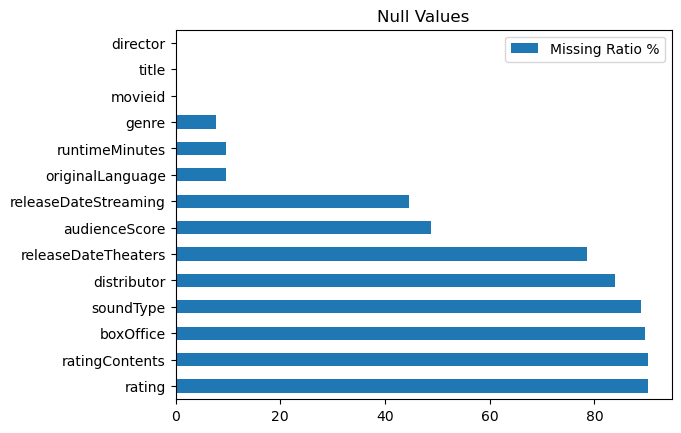

In [3]:
#Checking Null Values
import matplotlib.pyplot as plt
def plot_missing(df):
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.title('Null Values')
        plt.show()
plot_missing(movies)

In [4]:
print(f"No. of duplicate rows is {len(movies)-len(movies.drop_duplicates())}")
print(f"Movieid column has {len(movies)-len(movies.drop_duplicates(subset = ['movieid']))} duplicates")

No. of duplicate rows is 1571
Movieid column has 16854 duplicates


In [5]:
genre_pivot = movies.pivot_table(index = ['genre'], aggfunc ='size').sort_values(ascending=False).reset_index()
genre_pivot.columns = ['Genre', '#Count']
genre_pivot.loc[:5]

,Genre,#Count
0,Drama,27860
1,Documentary,15162
2,Comedy,11514
3,Mystery & thriller,7015
4,"Comedy, Drama",5479
5,Horror,5129


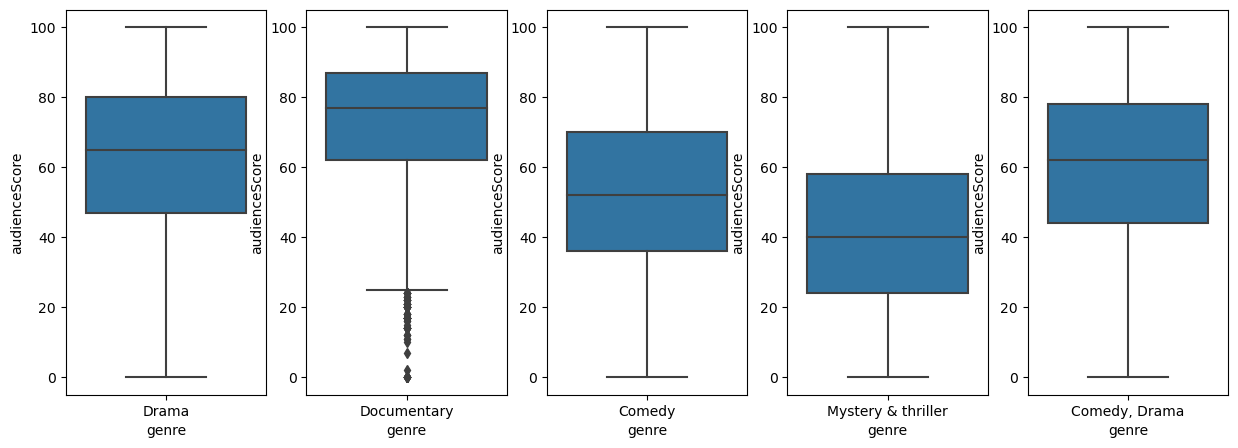

In [6]:
#Box Plot
import seaborn as sns
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
top_5 = list(genre_pivot.Genre.loc[:4])
i=0
for val in top_5:
    sns.boxplot(x = movies.genre[movies.genre == val], y = movies.audienceScore, ax=axes[i])
    i+=1

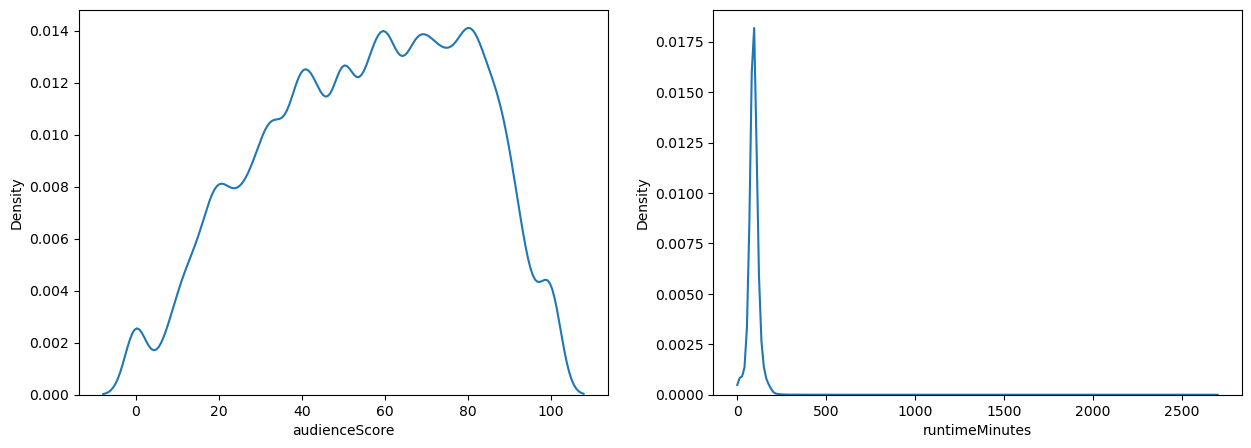

In [7]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.kdeplot(data=movies['audienceScore'], ax = ax[0])
sns.kdeplot(data=movies['runtimeMinutes'],bw_adjust = 5, cut = 0, ax = ax[1]);

### **Train Dataset** 🚄


#### <mark>Insights:</mark>

* There are missing values in the reviewText column

* NEGATIVE sentiments: 53997  (33.17%) 

  POSITIVE sentiments: 108761 (66.82%) 

* Classes are imbalanced. Can use StratifiedKFold for cross-validation.

* Because the classes are imbalanced, f1 score can be used to evaluate our model same as the compeition metric.

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [9]:
train.isna().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

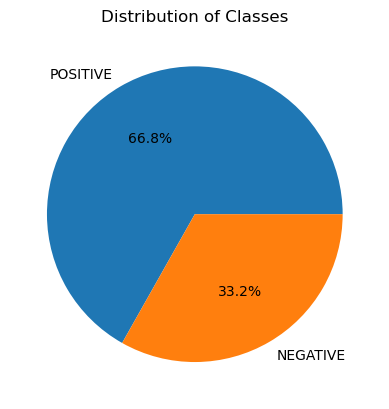

In [10]:
#Indicates class imbalance
plt.pie(train.sentiment.value_counts(), labels = train.sentiment.unique(), autopct='%1.1f%%')
plt.title('Distribution of Classes');

In [11]:
train_pivot = train.pivot_table(index = ['movieid'], aggfunc='size').sort_values(ascending = False).reset_index()
train_pivot.columns = ['movieid', 'no_of_reviews']
train_pivot

,movieid,no_of_reviews
0,escape_the_terminator_tyler_durden_astonish,708
1,fantasy_forrest_gump_intrigue,245
2,james_t._kirk_marty_mcfly_astonish,186
3,marvelous_lara_croft_luke_skywalker,140
4,michael_corleone_v_marty_mcfly_tony_stark,138
...,...,...
16807,luke_skywalker_sherlock_holmes_darth_vader,1
16808,luke_skywalker_sherlock_holmes_sapphire,1
16809,luke_skywalker_spectacular_michael_corleone_mi...,1
16810,luke_skywalker_tony_montana_rocky_balboa,1


#### Adding Features and Checking Impact

In [12]:
#Create Movie_Score based on Ratio of Positive and Negative Reviews
movie_pivot = pd.DataFrame(train.pivot_table(index = ['movieid','sentiment'], aggfunc ='size')).reset_index()
movie_pivot.columns = ['movieid', 'sentiment', 'count']
movie_pivot = movie_pivot.pivot(index='movieid', columns='sentiment', values='count').fillna(0).reset_index().rename_axis(None, axis=1)
movie_pivot['movie_score'] = round((movie_pivot['POSITIVE']) / (movie_pivot['POSITIVE']+movie_pivot['NEGATIVE']),2)
movie_pivot = movie_pivot.drop(['NEGATIVE','POSITIVE'],axis = 1)

#Create Reviewer Score column based on Ratio of Positive and Negative Reviews given by a Reviewer
review_pivot = pd.DataFrame(train.pivot_table(index = ['reviewerName','sentiment'], aggfunc ='size')).reset_index()
review_pivot.columns = ['reviewerName', 'sentiment', 'count']

#Pivot rows to columns
review_pivot = review_pivot.pivot(index='reviewerName', columns='sentiment', values='count').fillna(0).reset_index().rename_axis(None, axis=1)
review_pivot['reviewer_score'] = round(review_pivot['POSITIVE'] / (review_pivot['POSITIVE'] + review_pivot['NEGATIVE']),2)
review_pivot = review_pivot.drop(['NEGATIVE','POSITIVE'],axis = 1)

#Adding new features to training data
train_df = train.copy()
train_df['review_length'] = train_df['reviewText'].astype(str).apply(len)
train_df['word_count'] = train_df['reviewText'].apply(lambda x: len(str(x).split()))
train_df = train_df.merge(movie_pivot, on = 'movieid', how = 'left')
train_df = train_df.merge(review_pivot, on = 'reviewerName', how = 'left')
train_df.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,review_length,word_count,movie_score,reviewer_score
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,84,11,0.69,0.90
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,152,24,0.09,0.58
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE,128,22,0.81,0.49
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE,192,34,0.73,0.83
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE,141,20,0.91,0.71


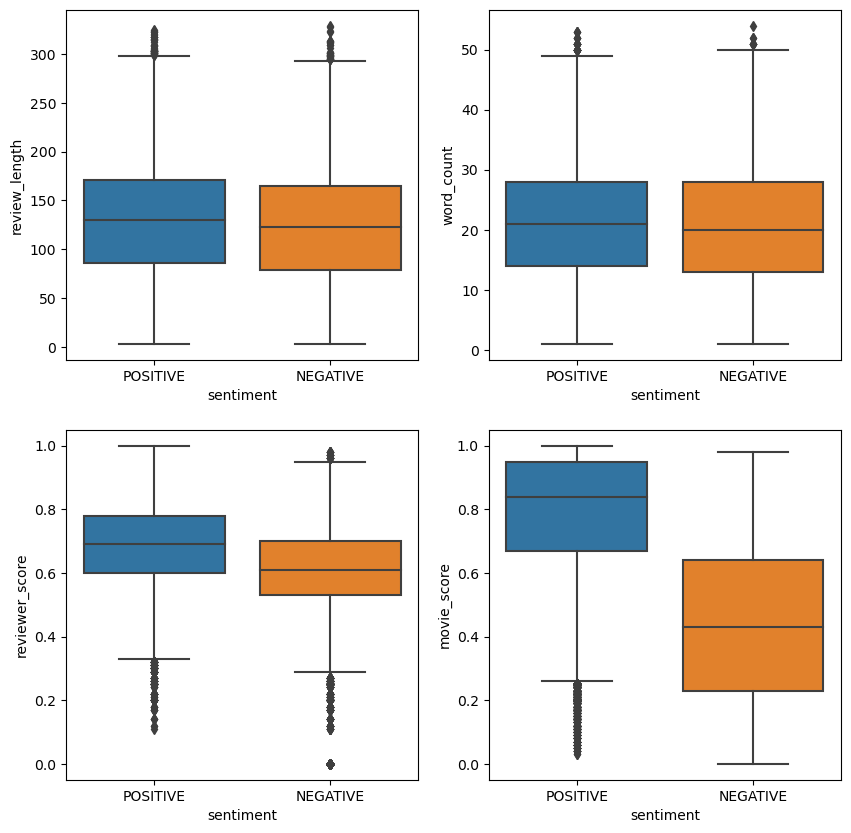

In [13]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
sns.boxplot(data = train_df, x = 'sentiment', y = 'review_length', ax = ax[0, 0])
sns.boxplot(data = train_df, x = 'sentiment', y = 'word_count', ax = ax[0, 1])
sns.boxplot(data = train_df, x = 'sentiment', y = 'reviewer_score', ax = ax[1, 0])
sns.boxplot(data = train_df, x = 'sentiment', y = 'movie_score', ax = ax[1, 1]);
#Conclustion: Review Length, Word count have no impact on sentiment
# Movie Score and Reviewer Score have much outliers 

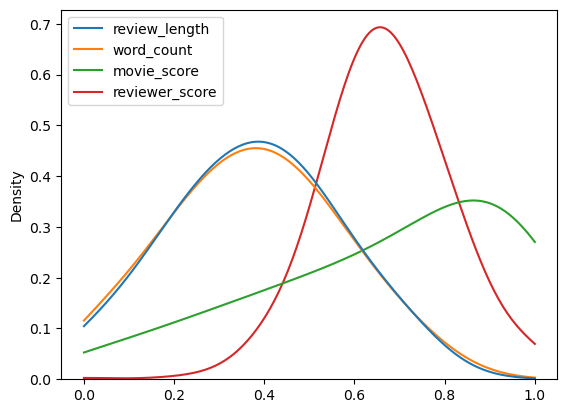

In [14]:
#Plotting Distributions (KDE Plot)
from sklearn.preprocessing import MinMaxScaler
df2 = train_df.copy()
scale = MinMaxScaler()
for col in df2.select_dtypes(include=[np.number]):
    df2[col] = scale.fit_transform(df2[[col]])
sns.kdeplot(data=df2[['review_length', 'word_count', 'movie_score', 'reviewer_score']],bw_adjust = 5, cut = 0);

**Movie Score:** Distribution shows high density of movies around 0.8 score, which confirms the class imbalance in the dataset

**Reviewer Score:** Distribution shows high density around 0.7 score

**Word Count/Review Length:** Have the same distributions

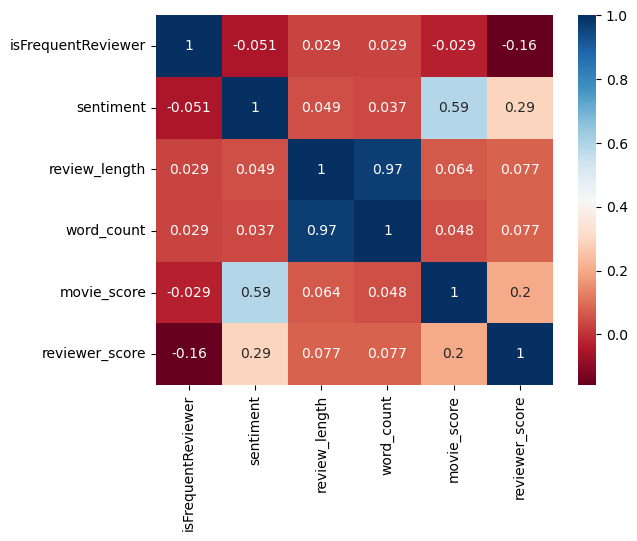

In [15]:
train_corr = train_df.copy()
train_corr.sentiment = train_corr.sentiment.replace({'POSITIVE':1, 'NEGATIVE':0}) 
corr = train_corr.corr(numeric_only=True)
sns.heatmap(corr, cmap='RdBu', annot=True);

Only Movie Score and Reviewer Score features seem to be correlated with the sentiment, but we know that the class in the dataset are imbalanced, the amount of movies with positive sentiment are very high, therefore movie score and reviewer score features might not be much useful to predict sentiment of reviewText

In [16]:
#Dropping these features
train_df = train_df.drop(['review_length', 'word_count', 'movie_score', 'reviewer_score'], axis = 1)

# Text Analysis

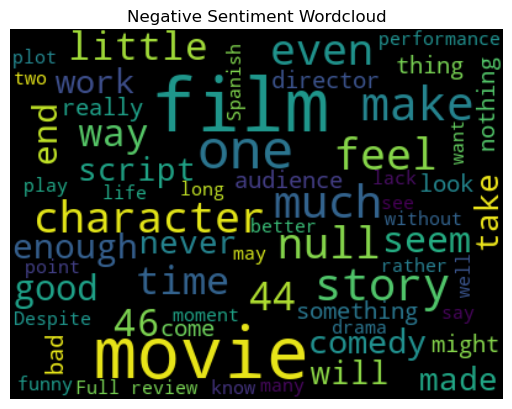

In [17]:
#Clean Review Text
# import html 
# def clean_text(text):
#     fix = html.unescape(str(text)) #Change encoding
#     fix = fix.encode("ascii","ignore")
#     output = fix.decode()
#     output = re.sub(r'[^\w\s]','',output) #Remove punctuations
#     return str(output)

text_df = train_df.copy()
text_df.reviewText.fillna('null', inplace = True)

#Word cloud for Negative Reviews
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(stopwords = STOPWORDS, max_font_size=60, include_numbers = True, max_words = 60, width=400, height=300)
wordcloud.generate(' '.join(text_df.reviewText[text_df['sentiment'] == 'NEGATIVE']))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Negative Sentiment Wordcloud')
plt.axis("off");

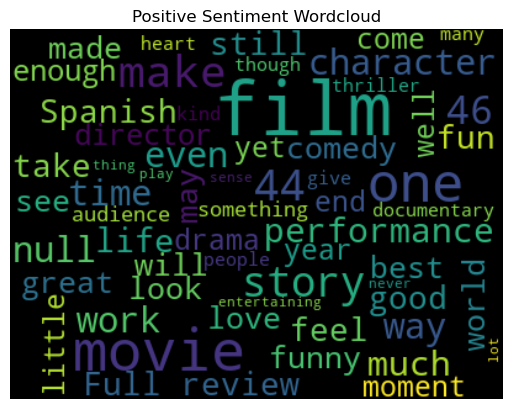

In [18]:
#Word cloud for Positive Reviews
wordcloud.generate(' '.join(text_df.reviewText[text_df['sentiment'] == 'POSITIVE']))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Positive Sentiment Wordcloud')
plt.axis("off");

# Merged Dataset

In [19]:
#Merge

#Drop Duplicates from movies dataset
movies_df = movies.drop_duplicates(subset = ['movieid'])

#Merge Train
df_merged = pd.merge(train_df, movies_df, how = 'left', on = 'movieid')

#Merge Test
df_merged_test = pd.merge(test, movies_df, how = 'left', on = 'movieid')
df_merged_test.rename(columns = {'isTopCritic':'isFrequentReviewer'}, inplace = True)

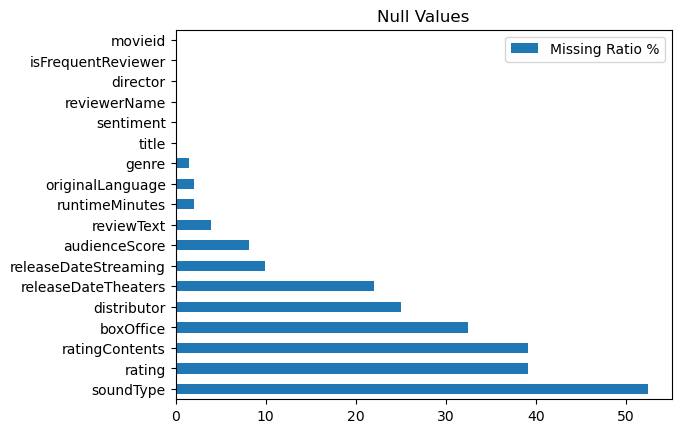

In [20]:
plot_missing(df_merged)

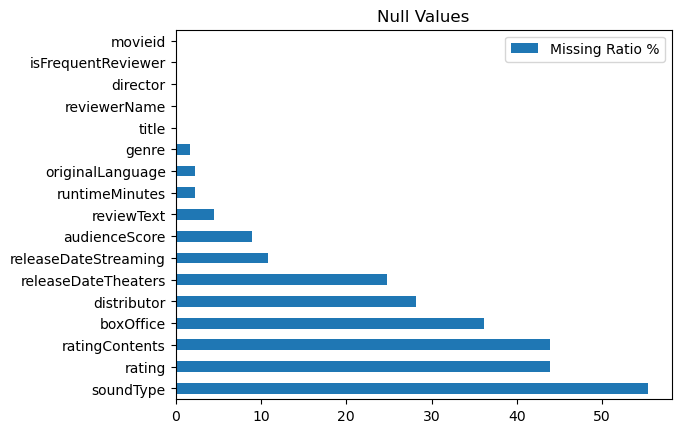

In [21]:
plot_missing(df_merged_test)

> **Columns having less than 10% Null Values would be useful**

In [22]:
#Merge Strategy 2
# #Take only columns with less nulls
# movies_df = movies[['movieid', 'title', 'genre','runtimeMinutes','originalLanguage','director', 'audienceScore']]

# #Fill blanks
# movies_df['runtimeMinutes'] = movies_df['runtimeMinutes'].fillna(movies_df['runtimeMinutes'].mean())

# #Group duplicates to avoid losing information
# movies_df = movies_df.groupby('movieid').agg({'genre': ', '.join, 'runtimeMinutes':'first', 'originalLanguage': ', '.join, 'director': ', '.join}).reset_index()

# #Trim duplicates in cells
# movies_df['originalLanguage'] = movies_df['originalLanguage'].str.split(', ').apply(set).str.join(', ')
# movies_df['director'] = movies_df['director'].str.split(', ').apply(set).str.join(', ')
# movies_df['genre'] = movies_df['genre'].str.split(', ').apply(set).str.join(', ')

# #Drop duplicates having least information
# movies_df = (movies_df.assign(counts=movies_df.count(axis=1))).sort_values(['movieid', 'counts'])

# #Sort by rows having least nulls and keep the last row
# movies_df = movies_df.drop_duplicates('movieid', keep='last').drop('counts', axis=1)
# movies_df.shape

In [23]:
# from ydata_profiling import ProfileReport
# ProfileReport(movies, title="Movies Dataset Report").to_file("movies_report.html")

### Correlation Heat Map

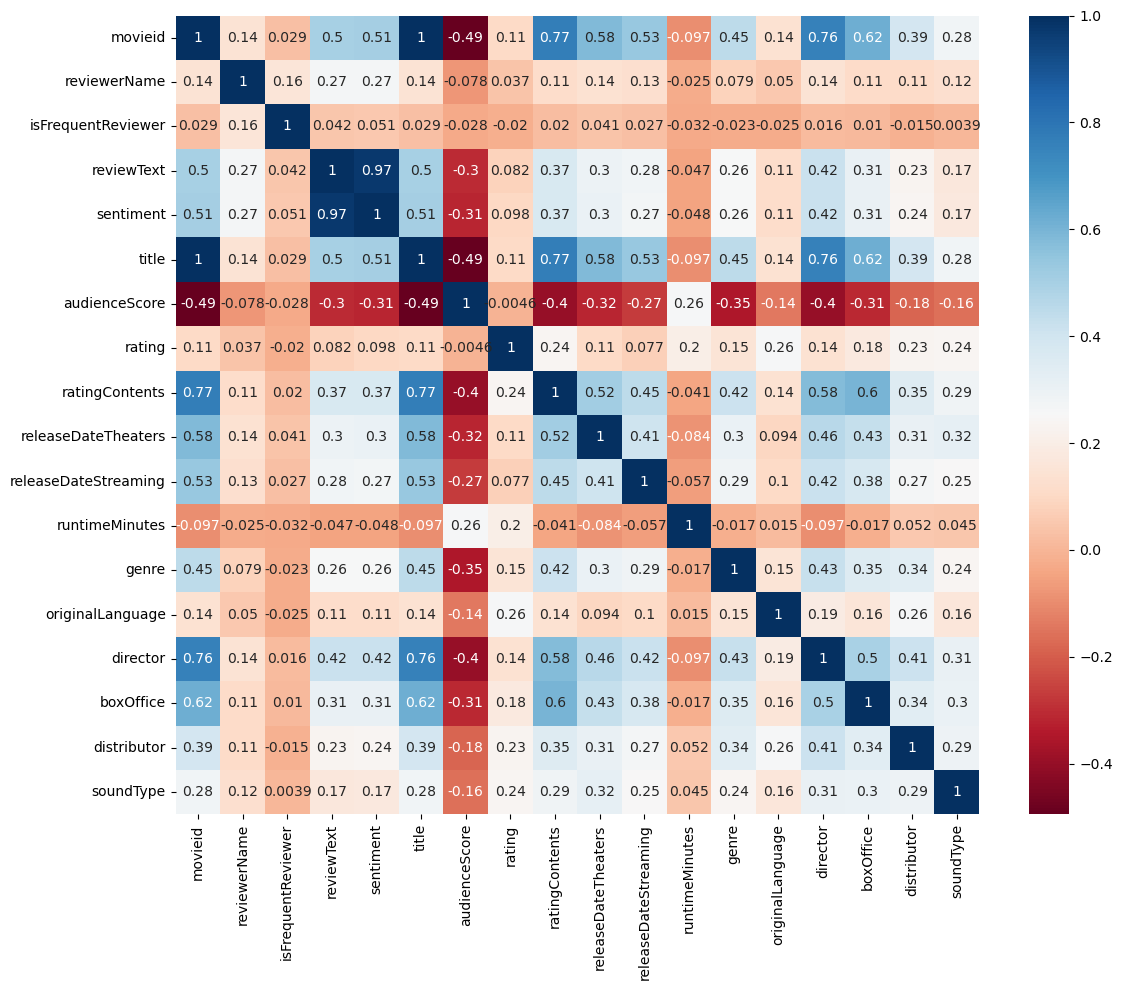

In [24]:
from category_encoders import TargetEncoder
enc = TargetEncoder(return_df = True)
dfe = df_merged.copy()
dfe['sentiment'] = dfe['sentiment'].replace({'POSITIVE':0, 'NEGATIVE':1})
for col in dfe.select_dtypes(include = 'object'):
    if col!=('sentiment'):
        dfe[col] = enc.fit_transform(dfe[col], dfe['sentiment'])

corr = dfe.corr()
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(corr, cmap='RdBu', annot=True, ax = ax)
plt.tight_layout();

In [25]:
from sklearn.feature_selection import mutual_info_classif
dfe = dfe.fillna(0)
for col in dfe.columns:
    print(f"{col}: {mutual_info_classif(dfe[[col]], dfe['sentiment'])}")

movieid: [0.19935255]
reviewerName: [0.0456391]
isFrequentReviewer: [0.00066342]
reviewText: [0.62805823]
sentiment: [0.64404917]
title: [0.20017023]
audienceScore: [0.05191396]
rating: [0.00957418]
ratingContents: [0.0898373]
releaseDateTheaters: [0.05914598]
releaseDateStreaming: [0.04145089]
runtimeMinutes: [0.00627111]
genre: [0.03412555]
originalLanguage: [0.02059579]
director: [0.12398349]
boxOffice: [0.05985941]
distributor: [0.03724827]
soundType: [0.01873137]


In [26]:
dff = df_merged.drop('sentiment', axis = 1).copy()
uniques = pd.DataFrame()
uniques['Feature'] = [i for i in dff.columns]
uniques['# Unique_Values'] = [dff[i].nunique() for i in dff.columns]
uniques.sort_values(by = '# Unique_Values', ascending = False).reset_index()
uniques.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Feature,movieid,reviewerName,isFrequentReviewer,reviewText,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
# Unique_Values,16812,4482,2,155071,16812,100,7,4477,4226,2899,216,1162,91,9476,3526,1610,437


### Choice of Encoders:

* OneHot Encoding: Would increase the dimensions by a significant amount, need to reduce infrequent categories

* Label/Ordinal Encoding: Our data is nominal so this would not apply to our data 

* Tfi-Df/Count Vectorizer: Potential for Review Text column


# Pre-Processing 🚧

In [27]:
from collections import Counter
def cumulatively_categorise(column,t=0.8,return_categories_list=True):
  threshold_value=int(t*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s = 0
  #Create a counter dictionary of the form unique_value: frequency
  counts = Counter(column)
  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
       break
  #Append the category Other to the list
  categories_list.append('Other')
  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')
  #Return transformed column and unique values if return_categories=True
  return new_column

#Reducing categories in train and test
df_merged['director'] = cumulatively_categorise(df_merged['director'])
df_merged['reviewerName'] = cumulatively_categorise(df_merged['reviewerName'])
df_merged['originalLanguage'] = cumulatively_categorise(df_merged['originalLanguage'])

df_merged_test['director'] = cumulatively_categorise(df_merged_test['director'])
df_merged_test['reviewerName'] = cumulatively_categorise(df_merged_test['reviewerName'])
df_merged_test['originalLanguage'] = cumulatively_categorise(df_merged_test['originalLanguage'])

In [28]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, OneHotEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LogisticRegression

one_dim = FunctionTransformer(np.reshape, kw_args={'newshape':-1})
ohe = OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency = 3)

#Make Pipeline
text_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value= 'missing'), one_dim, TfidfVectorizer(ngram_range = (1,2), strip_accents = 'ascii'))

imputer_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value= 'missing'), OneHotEncoder(handle_unknown = 'ignore'))

num_pipe = make_pipeline(SimpleImputer(), MaxAbsScaler())

#Transformer
num_features = ['audienceScore', 'runtimeMinutes']

num_transformer = make_column_transformer((num_pipe, num_features), remainder = 'drop')

text_transformer = ColumnTransformer([
     ('movieid', ohe, ['movieid']),
     ('reviewerName', ohe, ['reviewerName']),
     ('reviewText', text_pipe, ['reviewText']),
     ('originalLanguage', imputer_pipe, ['originalLanguage']),
     ('isfreq', OrdinalEncoder(), ['isFrequentReviewer']),
     ('director', ohe, ['director'])],
     remainder ='drop')

preprocessor = FeatureUnion([("Categorical Features", text_transformer), ("Numeric Features", num_transformer)])

preprocessor

FeatureUnion(transformer_list=[('Categorical Features',
                                ColumnTransformer(transformers=[('movieid',
                                                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                               min_frequency=3),
                                                                 ['movieid']),
                                                                ('reviewerName',
                                                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                               min_frequency=3),
                                                                 ['reviewerName']),
                                                                ('reviewText',
                                                                 Pipeline(steps=[('simpleimputer',
                                                                                  SimpleImputer(fill_valu...
                                                                 ['originalLanguage']),
                                                                ('isfreq',
                                                                 OrdinalEncoder(),
                                                                 ['isFrequentReviewer']),
                                                                ('director',
                                                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                               min_frequency=3),
                                                                 ['director'])])),
                               ('Numeric Features',
                                ColumnTransformer(transformers=[('pipeline',
                                                                 Pipeline(steps=[('simpleimputer',
                                                                                  SimpleImputer()),
                                                                                 ('maxabsscaler',
                                                                                  MaxAbsScaler())]),
                                                                 ['audienceScore',
                                                                  'runtimeMinutes'])]))])

In [29]:
#Prepare and split data
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

y = df_merged['sentiment']
x = df_merged.drop(['sentiment'],axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state= 42, stratify = y)

# Model 🗿

## **Logistic Regression** 👽

In [30]:
%%time
# parameter grid
parameters = {
    'Model__C'       : np.arange(0.8,2.0,0.4),
#     'feature__percentile' : [60,68,76]
}

logistic = LogisticRegression(random_state=42, max_iter = 1000)
selector = SelectPercentile(chi2)

logisticcv_pipeline = Pipeline([('Process',preprocessor), ('Select',selector), ('Model',logistic)])

cval = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)

grid = GridSearchCV(logisticcv_pipeline,      # model
                   param_grid = parameters,   # hyperparameters
                   scoring='f1_micro',        # metric for scoring
                   cv=cval,                   # stratified cross validation
                   n_jobs=-1)                      

# grid.fit(x,y)
# print("Tuned Hyperparameters :", grid.best_params_)
# print("Score :",grid.best_score_)

CPU times: user 86 µs, sys: 7 µs, total: 93 µs
Wall time: 105 µs


In [31]:
%%time
from sklearn.linear_model import LogisticRegression

logi = LogisticRegression(C = 1.6, random_state = 42, solver = 'sag')

pipe_logistic = Pipeline([
    ('Transform',preprocessor),
    ('Reduce', SelectPercentile(chi2, percentile = 88)),
    ('Fitting Model',logi)])

pipe_logistic.fit(x_train, y_train)

#Predict on testing data
y_pred_logi = pipe_logistic.predict(x_test)

#Print classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_logi))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.68      0.73     10800
    POSITIVE       0.85      0.91      0.88     21752

    accuracy                           0.83     32552
   macro avg       0.82      0.80      0.81     32552
weighted avg       0.83      0.83      0.83     32552

CPU times: user 47.5 s, sys: 553 ms, total: 48.1 s
Wall time: 47.7 s


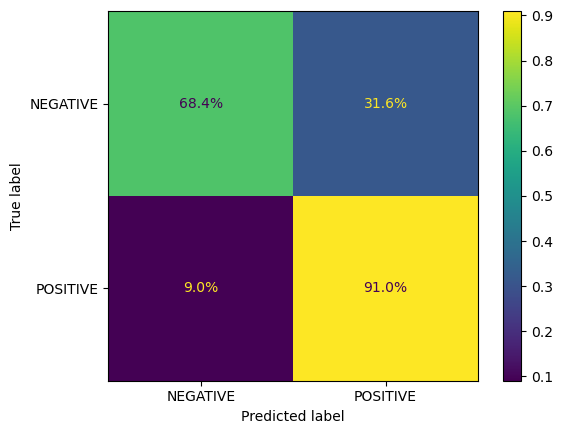

In [32]:
#Print Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logi, values_format='.01%', normalize = 'true');

## **LinearSVC** 🐛

In [33]:
%%time
from sklearn.metrics import classification_report, accuracy_score

from sklearn.svm import LinearSVC

pipe_svm = Pipeline([
    ('Transform', preprocessor),
    ('Feature Selection',SelectPercentile(chi2, percentile = 88)),
    ('Model',LinearSVC(C = 0.39, random_state = 42, dual = False))])

pipe_svm.fit(x_train, y_train)
y_pred_svm = pipe_svm.predict(x_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.71      0.75     10800
    POSITIVE       0.86      0.91      0.88     21752

    accuracy                           0.84     32552
   macro avg       0.83      0.81      0.82     32552
weighted avg       0.84      0.84      0.84     32552

CPU times: user 1min 32s, sys: 53.8 s, total: 2min 26s
Wall time: 51.5 s


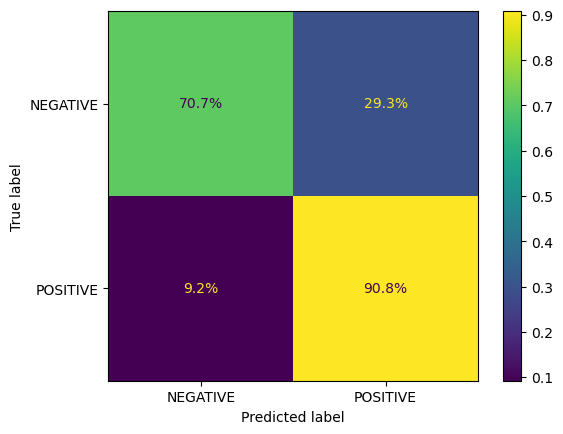

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, values_format='.01%', normalize = 'true');

## **SGD Classifier** 🦊

In [35]:
%%time
#SGD CLASSIFIER
from sklearn.linear_model import SGDClassifier
pipe_sgd = Pipeline([
    ('Transform', preprocessor),
    ('Feature Selection',SelectPercentile(chi2, percentile = 88)),
    ('Model', SGDClassifier(alpha = 0.00001, random_state = 42, loss = "modified_huber", n_jobs = -1, eta0 = 0.01, learning_rate='adaptive'))])

#Training 
pipe_sgd.fit(x_train,y_train)

# #Predict on testing data
y_pred_sgd = pipe_sgd.predict(x_test)
print(classification_report(y_test, y_pred_sgd))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.71      0.75     10800
    POSITIVE       0.86      0.90      0.88     21752

    accuracy                           0.84     32552
   macro avg       0.83      0.81      0.82     32552
weighted avg       0.84      0.84      0.84     32552

CPU times: user 24.3 s, sys: 576 ms, total: 24.9 s
Wall time: 24.3 s


In [36]:
# from sklearn.model_selection import cross_val_score
# cval = cross_val_score(pipe_sgd, x, y, cv = 5)
# print(cval)

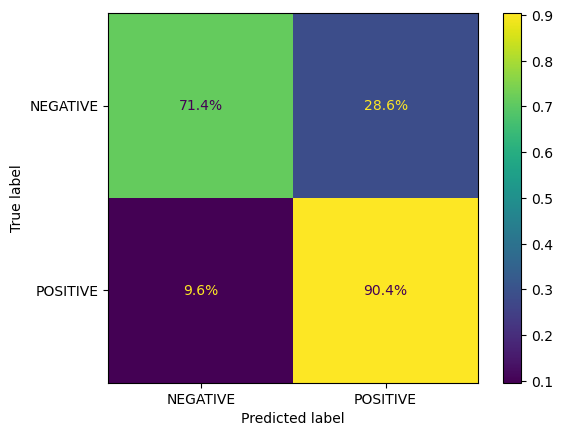

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sgd, values_format='.01%', normalize = 'true');

<div class="alert alert-block alert-info">
SGDClassifier performs much better at predicting Negative Sentiments than other models, this is due to modified huber cost function which is robust to outliers

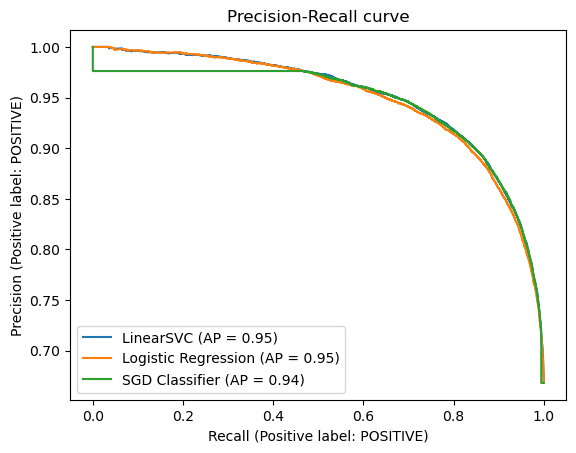

In [38]:
# Plot precision-recall curve
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(pipe_svm, x_test, y_test, name="LinearSVC", ax = ax)
PrecisionRecallDisplay.from_estimator(pipe_logistic, x_test, y_test, name="Logistic Regression",ax = ax)
PrecisionRecallDisplay.from_estimator(pipe_sgd, x_test, y_test, name="SGD Classifier",ax = ax)
plt.title("Precision-Recall curve");

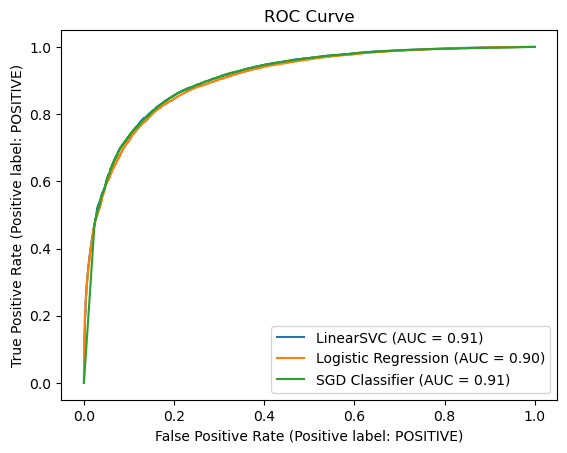

In [39]:
# Plot ROC Curve
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(pipe_svm, x_test, y_test, name="LinearSVC", ax = ax)
RocCurveDisplay.from_estimator(pipe_logistic, x_test, y_test, name="Logistic Regression",ax = ax)
RocCurveDisplay.from_estimator(pipe_sgd, x_test, y_test, name="SGD Classifier",ax = ax)
plt.title("ROC Curve");

In [40]:
from sklearn.metrics import accuracy_score
print('Accuracy Score')
print(f"Logistic Regression: {round(accuracy_score(y_test, y_pred_logi),6)}")
print(f"Linear SVC: {round(accuracy_score(y_test, y_pred_svm),6)}")
print(f"SGD Classifier: {round(accuracy_score(y_test, y_pred_sgd),6)}")

Accuracy Score
Logistic Regression: 0.834726
Linear SVC: 0.841208
SGD Classifier: 0.841208


In [41]:
from sklearn.metrics import f1_score
print('F1 Score')
print(f"Logistic Regression: {round(f1_score(y_test, y_pred_logi, average='macro'),6)}")
print(f"Linear SVC: {round(f1_score(y_test, y_pred_svm, average='macro'),6)}")
print(f"SGD Classifier: {round(f1_score(y_test, y_pred_sgd, average='macro'),6)}")

F1 Score
Logistic Regression: 0.806673
Linear SVC: 0.815686
SGD Classifier: 0.816461


<div class="alert alert-block alert-success">
<b>👌</b> Linear SVC/SGD Classifier gives almost same scores, but SGD Classifier runs almost 50% faster as we can see from the runtime and performs better on predicting Negative Sentiments
</div>

In [42]:
#Submission CSV
pipe_sgd.fit(x, y)
y_pred_test = pipe_sgd.predict(df_merged_test)
submission = pd.DataFrame(columns = ['id','sentiment'])
submission['id'] = [i for i in range(len(test))]
submission['sentiment'] = y_pred_test
submission.to_csv('submission.csv',index = False)
print('Submission file generated!')

Submission file generated!


<blockquote><h2><span style="color:blue">T</span><span style="color:green">h</span><span style="color:red">a</span><span style="color:#ff66ff">n</span><span style="color:#ff66ff">k</span> <span style="color:green">you</span> &#9786;</h2></blockquote>